## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import shutil

## Download the Dataset

In [2]:
RAW_DATA_DIR = "data/raw"
BASE_DIR = os.path.join(RAW_DATA_DIR, "cell_images") # Where Kaggle dataset is unzipped
CLEAN_DIR = os.path.join(RAW_DATA_DIR, "clean_cell_images") # Clean folder for training

# Make sure raw folder exists
os.makedirs(RAW_DATA_DIR, exist_ok=True)

# Set Kaggle config directory to current folder
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

# Check for kaggle.json (you need to upload it in Colab first)
if not os.path.exists('kaggle.json'):
    raise FileNotFoundError("Kaggle API token file 'kaggle.json' not found. Please upload it to the current directory.")

# Download & unzip dataset **only if it doesn't exist**
if not os.path.exists(BASE_DIR):
    !kaggle datasets download -d 'iarunava/cell-images-for-detecting-malaria' -p {RAW_DATA_DIR} --unzip
else:
    print("Dataset already downloaded and unzipped.")

# Detect whether there is a nested cell_images folder
if os.path.exists(os.path.join(BASE_DIR, "cell_images")):
  # Nested case: cell_images/cell_images/Parasitized
  DATA_SOURCE_DIR = os.path.join(BASE_DIR, "cell_images")
else:
  # Normal case: cell_images/Parasitized
  DATA_SOURCE_DIR = BASE_DIR

print("Using data source dictionary:", DATA_SOURCE_DIR)

# Remove old clean folder if it exists
if os.path.exists(CLEAN_DIR):
  shutil.rmtree(CLEAN_DIR)

# Copy clean structure
shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Parasitized"),
    os.path.join(CLEAN_DIR, "Parasitized")
)

shutil.copytree(
    os.path.join(DATA_SOURCE_DIR, "Uninfected"),
    os.path.join(CLEAN_DIR, "Uninfected")
)

print("Clean dataset ready at:", CLEAN_DIR)

DATA_SET_PATH = 'data/raw/clean_cell_images'
# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,    # Shift images horizontally by up to 10%
    height_shift_range=0.1,   # Shift images vertically by up to 10%
    shear_range=0.2,          # Shear transformations
    zoom_range=0.1,           # Zoom in/out randomly
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill in new pixels after transformations
    validation_split=0.2      # Reserve 20% of data for validation
)

# Validation Data Generator
val_datagen = ImageDataGenerator(
    rescale=1./255,           # Only normalize pixel values for validation
    validation_split=0.2
)

# Create Training Dataset Generator
train = train_datagen.flow_from_directory(
    CLEAN_DIR, # Path to dataset
    target_size=(128,128),                    # Resize all images to 128x128 pixels
    batch_size=32,                            # Number of images per batch
    class_mode='binary',                      # Binary classification: Parasitized vs Uninfected
    subset='training',                        # Uses 80% of images for training
    shuffle=True                              # Shuffle images each epoch
)

# Create Validation Dataset Generator
val = val_datagen.flow_from_directory(
    CLEAN_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',                      # Uses 20% of images for validation
    shuffle=False                             # No need to shuffle for validation
    )

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 99% 668M/675M [00:00<00:00, 1.74GB/s]
100% 675M/675M [00:00<00:00, 1.74GB/s]
Using data source dictionary: data/raw/cell_images/cell_images
Clean dataset ready at: data/raw/clean_cell_images
Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Load the Dataset

In [3]:
DATA_SET_PATH = 'data/raw/clean_cell_images'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    DATA_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

class_names = list(val_generator.class_indices.keys())
print(class_names)

Found 5510 images belonging to 2 classes.
['Parasitized', 'Uninfected']


## Load Models

In [4]:
cnn_model = load_model("/content/models/custom_cnn.keras")
mobilenet_frozen = load_model("/content/models/malaria_mobilenetv2_frozen.keras")
mobilenet_finetuned = load_model("/content/models/malaria_mobilenetv2_finetuned.keras")

## Plot Confusion Matrix

In [5]:
def plot_confusion(model, title):
  y_true = val_generator.classes
  y_pred = model.predict(val_generator)
  y_pred = (y_pred > 0.5).astype(int).flatten()

  cm = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap="Blues")
  plt.title(title)
  plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


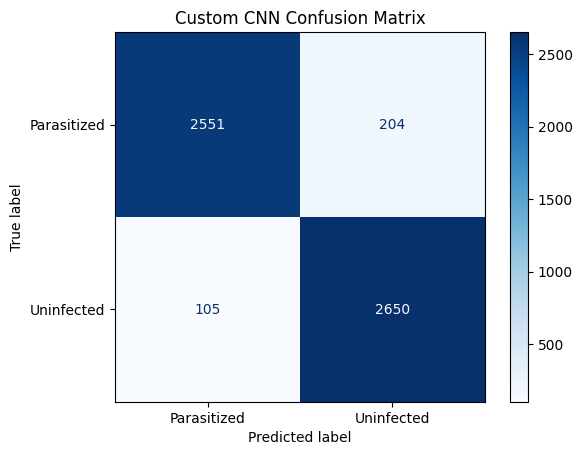

173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step


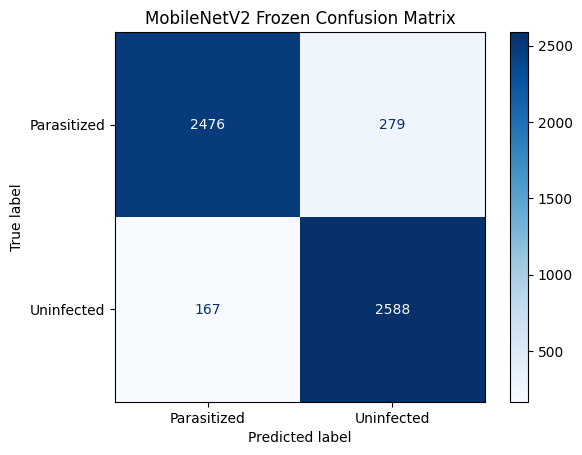

173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step


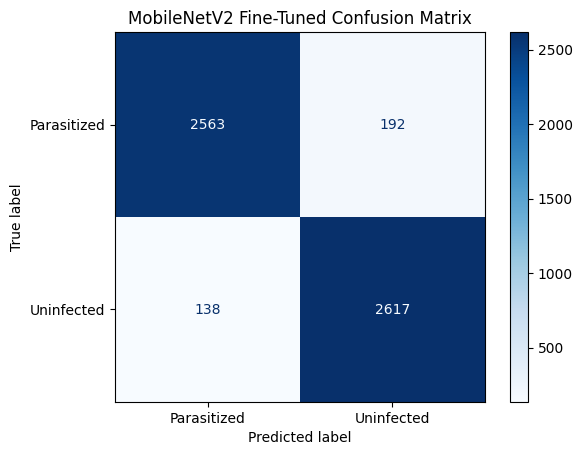

In [6]:
plot_confusion(cnn_model, "Custom CNN Confusion Matrix")
plot_confusion(mobilenet_frozen, "MobileNetV2 Frozen Confusion Matrix")
plot_confusion(mobilenet_finetuned, "MobileNetV2 Fine-Tuned Confusion Matrix")

## Save all the Confusion Matrices in One Figure

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


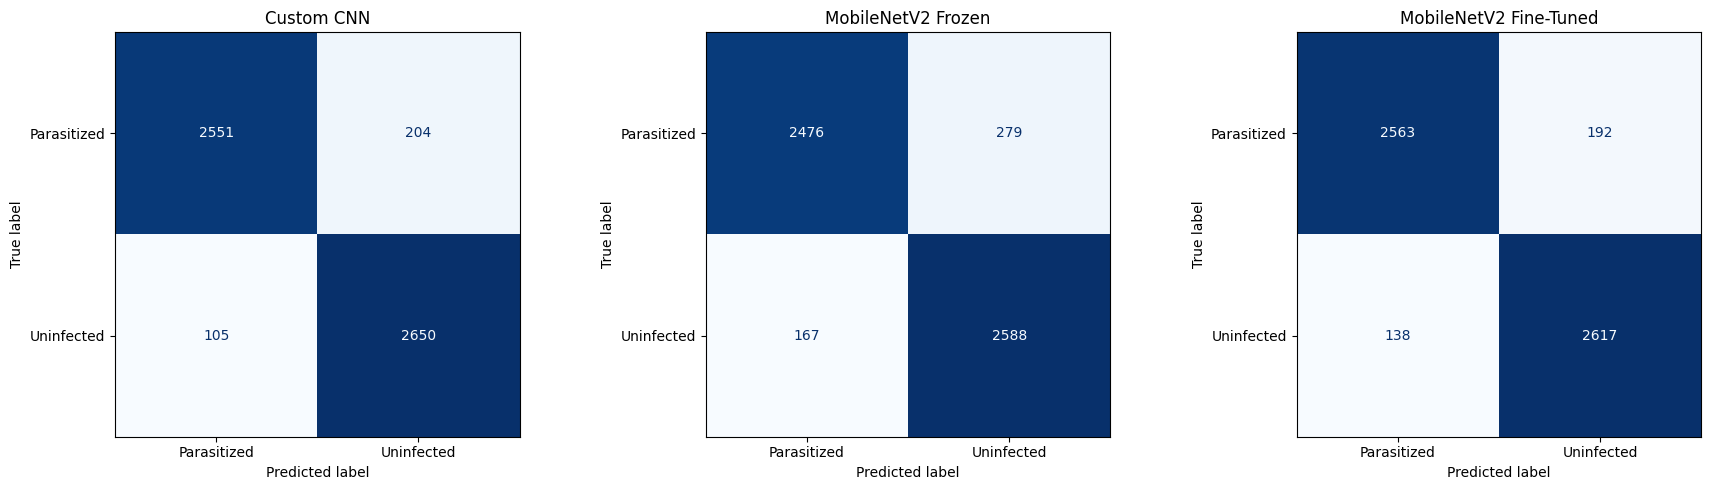

In [9]:
models = {
    "Custom CNN": cnn_model,
    "MobileNetV2 Frozen": mobilenet_frozen,
    "MobileNetV2 Fine-Tuned": mobilenet_finetuned
}

fig, axes = plt.subplots(1, 3,figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
  y_true = val_generator.classes
  y_pred = model.predict(val_generator)
  y_pred = (y_pred > 0.5).astype(int).flatten()

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
  disp.plot(ax=ax, cmap="Blues", colorbar=False)
  ax.set_title(name)

plt.tight_layout()
fig.savefig("results/all_confusion_matrices.png", dpi=300)
plt.show()

plt.close(fig)